In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [3]:
path= '/Users/shantamaraj/Desktop/Basketball Analytics/Processed Data/nba_3pt_data.csv'

In [4]:
df = pd.read_csv(path)

In [8]:
df.shape

(8046, 15)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8046 entries, 0 to 8045
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   season_start    8046 non-null   int64  
 1   season_end      8046 non-null   int64  
 2   player          8046 non-null   object 
 3   team            8046 non-null   object 
 4   games_played    8046 non-null   int64  
 5   minutes_played  8046 non-null   int64  
 6   3PM             8046 non-null   int64  
 7   3PA             8046 non-null   int64  
 8   3P%             8046 non-null   float64
 9   assists         8046 non-null   int64  
 10  turnovers       8046 non-null   int64  
 11  total_points    8046 non-null   int64  
 12  country         8046 non-null   object 
 13  team_fullname   8029 non-null   object 
 14  state           8029 non-null   object 
dtypes: float64(1), int64(9), object(5)
memory usage: 943.0+ KB


In [6]:
df.head()

,season_start,season_end,player,team,games_played,minutes_played,3PM,3PA,3P%,assists,turnovers,total_points,country,team_fullname,state
0,2012,2013,Kevin Durant,OKC,81,3119,139,334,0.416,374,280,2280,United States of America,Oklahoma City Thunder,Oklahoma
1,2012,2013,Kobe Bryant,LAL,78,3013,132,407,0.324,469,287,2133,United States of America,Los Angeles Lakers,California
2,2012,2013,LeBron James,MIA,76,2877,103,254,0.406,551,226,2036,United States of America,Miami Heat,Florida
3,2012,2013,James Harden,HOU,78,2985,179,486,0.368,455,295,2023,United States of America,Houston Rockets,Texas
4,2012,2013,Carmelo Anthony,NYK,67,2482,157,414,0.379,171,175,1920,United States of America,New York Knicks,New York


In [7]:
df.columns

Index(['season_start', 'season_end', 'player', 'team', 'games_played',
       'minutes_played', '3PM', '3PA', '3P%', 'assists', 'turnovers',
       'total_points', 'country', 'team_fullname', 'state'],
      dtype='object')

In [9]:
# Select numeric columns for clustering
cluster_data = df[['games_played', 'minutes_played', '3PM', '3PA', '3P%', 'assists', 'turnovers', 'total_points']]

# Check for missing values
cluster_data.isnull().sum()

games_played      0
minutes_played    0
3PM               0
3PA               0
3P%               0
assists           0
turnovers         0
total_points      0
dtype: int64

For clustering, I selected the most relevant numeric variables that reflect player performance and playing style:

- Games played  
- Minutes played  
- 3-point field goals made (3PM)  
- 3-point field goals attempted (3PA)  
- 3-point shooting percentage (3P%)  
- Assists  
- Turnovers  
- Total points  

These variables capture both volume and efficiency metrics, providing a well-rounded view of each player's offensive profile. Non-numeric columns such as player names, team, and country were excluded since K-means requires numerical data only.

In [10]:
# Create the scaler
scaler = StandardScaler()

# Fit and transform the data
scaled_data = scaler.fit_transform(cluster_data)

# Convert back into a DataFrame for readability
scaled_df = pd.DataFrame(scaled_data, columns=cluster_data.columns)

# View first few rows
scaled_df.head()

,games_played,minutes_played,3PM,3PA,3P%,assists,turnovers,total_points
0,1.552019,2.758069,2.042399,1.745535,0.824258,2.543527,4.144874,4.394614
1,1.445882,2.629285,1.903891,2.290199,0.302883,3.370750,4.269702,4.055706
2,1.375124,2.464053,1.330072,1.148644,0.767587,4.084775,3.181918,3.832073
3,1.445882,2.595267,2.833873,2.879629,0.552236,3.248844,4.412362,3.802101
4,1.056713,1.984151,2.398562,2.342427,0.614574,0.775881,2.272460,3.564635


### Data Standardization

Because the variables in the dataset are measured on different scales (ex- total points can reach hundreds while 3P% is a decimal), the data was standardized using scikit-learn’s `StandardScaler()`.

This process centers each variable around a mean of 0 and a standard deviation of 1, ensuring that all features contribute equally to the K-means clustering distance calculations.

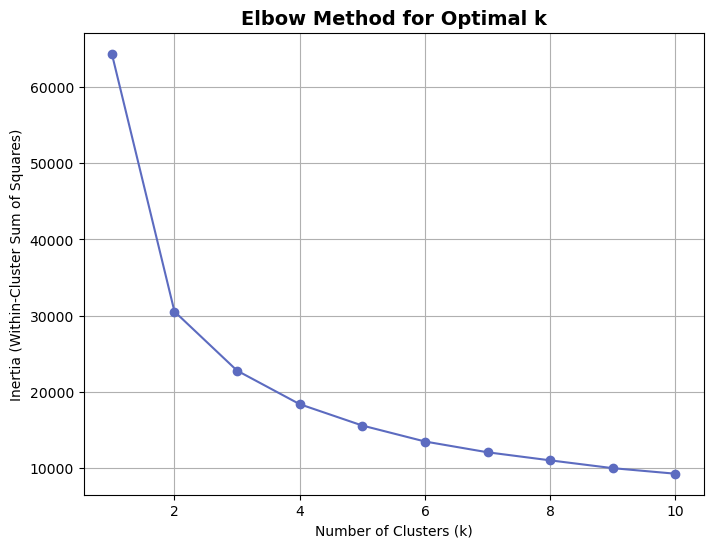

In [15]:
#Create a list to store the inertia (sum of squared distances)
inertia = []

# Test K values from 1 to 10
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_df)
    inertia.append(kmeans.inertia_)

#Plot Elbow method
plt.figure(figsize=(8,6))
plt.plot(range(1, 11), inertia, marker='o', color='#5C6BC0')
plt.title('Elbow Method for Optimal k', fontsize=14, fontweight='bold')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.grid(True)
plt.show()

### Elbow Method Results

The Elbow Method plot shows a steep decline in inertia between **k = 1** and **k = 3**, after which the curve begins to flatten.  
This indicates that **k = 3** provides the most efficient balance between model simplicity and explanatory power.

Therefore, I selected **3 clusters** as the optimal number for segmenting NBA players based on their performance metrics.

In [16]:
# Fit K-Means with optimal number of clusters (k=3)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans.fit(scaled_df)

# Add cluster labels to original dataframe
df['cluster'] = kmeans.labels_

# View cluster counts
print(df['cluster'].value_counts())

# Quick preview
df[['player', 'team', '3PA', '3P%', 'total_points', 'cluster']].head(10)

cluster
1    4466
2    2422
0    1158
Name: count, dtype: int64


,player,team,3PA,3P%,total_points,cluster
0,Kevin Durant,OKC,334,0.416,2280,0
1,Kobe Bryant,LAL,407,0.324,2133,0
2,LeBron James,MIA,254,0.406,2036,0
3,James Harden,HOU,486,0.368,2023,0
4,Carmelo Anthony,NYK,414,0.379,1920,0
5,Russell Westbrook,OKC,300,0.323,1903,0
6,Stephen Curry,GSW,600,0.453,1786,0
7,Monta Ellis,MIL,328,0.287,1577,0
8,Damian Lillard,POR,503,0.368,1562,0
9,LaMarcus Aldridge,POR,14,0.143,1560,2


### K-Means Model and Cluster Labels

Using the optimal number of clusters (**k = 3**) determined from the Elbow Method, a K-Means model was trained on the standardized performance variables.  
Each player was assigned a **cluster label (0, 1, or 2)** representing their membership in one of the three groups identified by the algorithm.

The resulting clusters capture distinct player profiles based on performance metrics such as scoring volume, 3-point shooting, and playmaking ability.  
Cluster counts show that most players fall into a mid-range performance group, while smaller groups represent high-volume scorers and lower-usage role players.

This clustering structure forms the foundation for further analysis and interpretation of player types in the next steps.

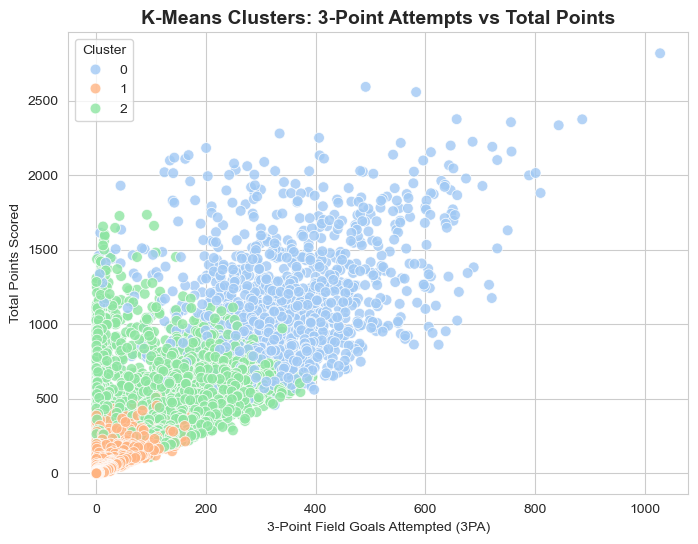

In [17]:
plt.figure(figsize=(8,6))
sns.set_style("whitegrid")

sns.scatterplot(
    data=df, 
    x='3PA', 
    y='total_points', 
    hue='cluster', 
    palette='pastel', 
    s=60, 
    alpha=0.8
)

plt.title('K-Means Clusters: 3-Point Attempts vs Total Points', fontsize=14, fontweight='bold')
plt.xlabel('3-Point Field Goals Attempted (3PA)')
plt.ylabel('Total Points Scored')
plt.legend(title='Cluster')
plt.show()

### K-Means Cluster Scatterplot 

A 2D scatterplot was created using **3-point attempts (3PA)** on the x-axis and **total points scored** on the y-axis, with colors representing the three cluster groups identified by the K-Means model.  

The plot shows clear visual separation among player types:  
- **Cluster 0 (blue):** High-volume, high-scoring players who attempt and make many 3-point shots — typically offensive leaders or star scorers.  
- **Cluster 1 (orange):** Moderate contributors who balance scoring with fewer shot attempts — likely role players or secondary scorers.  
- **Cluster 2 (green):** Lower-scoring players with minimal 3-point activity — often bench players or specialists with limited offensive roles.  

This visualization confirms that the clustering model successfully segmented the dataset into meaningful player performance groups, reflecting distinct styles and scoring capacities.

In [19]:
# Calculate average values for each variable by cluster
cluster_summary = df.groupby('cluster')[['games_played', 'minutes_played', '3PM', '3PA', '3P%', 'assists', 'turnovers', 'total_points']].mean().round(2)

# Display the summary table
cluster_summary

,games_played,minutes_played,3PM,3PA,3P%,assists,turnovers,total_points
cluster,,,,,,,,
0,71.39,2211.61,129.56,350.74,0.36,280.53,143.58,1157.63
1,14.90,218.71,7.24,21.86,0.23,16.54,10.89,80.49
2,61.75,1359.31,43.57,124.37,0.30,107.44,69.29,540.05


### Step 7: Analyze Cluster Characteristics

To better understand the differences between player groups, I calculated the average values for each key performance metric across the three clusters.

| Metric | Cluster 0 | Cluster 1 | Cluster 2 |
|:--|:--:|:--:|:--:|
| **Games Played** | 71.39 | 14.90 | 61.75 |
| **Minutes Played** | 2,211.61 | 218.71 | 1,359.31 |
| **3PM (3-Point Field Goals Made)** | 129.56 | 7.24 | 43.57 |
| **3PA (3-Point Field Goals Attempted)** | 350.74 | 21.86 | 124.37 |
| **3P% (3-Point Percentage)** | 0.36 | 0.23 | 0.30 |
| **Assists** | 280.53 | 16.54 | 107.44 |
| **Turnovers** | 143.58 | 10.89 | 69.29 |
| **Total Points** | 1,157.63 | 80.49 | 540.05 |

**Interpretation:**
- **Cluster 0 – Elite Scorers & Playmakers:**  
  These players log the highest minutes, make the most 3-point shots, and have the highest total points. Their strong assist numbers suggest that they contribute both as scorers and creators — typical of all-star level players like Kevin Durant, LeBron James, or Stephen Curry.
  
- **Cluster 1 – Bench or Low-Usage Players:**  
  This group plays very few minutes, has low scoring and shooting volume, and the lowest efficiency. Likely composed of reserve players or rookies who play limited roles or short rotations.
  
- **Cluster 2 – Reliable Starters / Role Players:**  
  Players in this group have solid playing time and balanced production. They contribute moderately across all stats — often starting-caliber players or consistent role contributors who support the team’s offensive rhythm.

Overall, these results confirm that the clustering model effectively segmented NBA players into three meaningful groups based on offensive volume and performance intensity.

The K-Means clustering analysis successfully segmented NBA players into three distinct groups based on key performance indicators such as 3-point shooting volume, scoring output, and minutes played.

- **Cluster 0 – Elite Scorers and Playmakers:**  
  High-impact players who dominate in minutes, scoring, and 3-point attempts. These are typically offensive leaders and All-Star caliber players responsible for driving team success.

- **Cluster 1 – Low-Usage or Bench Players:**  
  Players with minimal court time and limited offensive contributions. They often serve situational or developmental roles, contributing in short rotations or specialized defensive assignments.

- **Cluster 2 – Reliable Starters and Role Players:**  
  Players with consistent minutes and balanced production across metrics. They form the core of most rosters—dependable contributors who support star players through efficient, steady performance.

**Key Takeaway:**  
The clustering results reveal how player performance naturally divides into tiers of offensive responsibility and efficiency.  
This insight could help coaches, analysts, and scouts:
- Identify potential breakout players (Cluster 2 players trending toward Cluster 0 behavior).  
- Compare team rosters by player type and role distribution.  
- Target player archetypes for strategic lineup construction or trades.

Overall, this clustering analysis demonstrates the power of unsupervised learning in uncovering hidden performance patterns and informing data-driven decision-making in sports analytics.


## Clustering Analysis

In this exercise, I applied **K-Means clustering** to group NBA players based on performance metrics such as 3-point attempts, shooting percentage, assists, turnovers, and total points.  

After standardizing the data, the **Elbow Method** identified **three optimal clusters**, representing distinct player archetypes.  
Subsequent analysis and visualization revealed clear groupings of:
- **Cluster 0 – Elite Scorers and Playmakers:** High-impact offensive players who log significant minutes and contribute heavily to both scoring and assists.  
- **Cluster 1 – Low-Usage or Bench Players:** Individuals with limited playing time and minimal offensive output.  
- **Cluster 2 – Reliable Starters and Role Players:** Consistent contributors with balanced production across metrics.

This segmentation provides valuable insights into player roles and performance tiers, illustrating how unsupervised learning can uncover hidden patterns in basketball analytics.  
By understanding these player clusters, teams could identify lineup strengths, optimize rotations, and make data-driven decisions for player development and recruitment.

In [23]:
#Save dataframe with clusters column
output_path = "/Users/shantamaraj/Desktop/Basketball Analytics/Processed Data/3pt_clusters.csv"
df.to_csv(output_path, index=False)

In [24]:
df.columns

Index(['season_start', 'season_end', 'player', 'team', 'games_played',
       'minutes_played', '3PM', '3PA', '3P%', 'assists', 'turnovers',
       'total_points', 'country', 'team_fullname', 'state', 'cluster'],
      dtype='object')